<a href="https://colab.research.google.com/github/kachytronico/colab-PIA/blob/main/205_Columnas_categ%C3%B3ricas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Columnas categóricas

Durante los cuadernillos de este tema hemos visto cómo eliminar columnas que no resultaban útiles, tratar los nulos (recuerda: eliminándolos o añadiendo nuevos datos sintéticos), o justificar una eliminación por poca variabilidad.

Sin embargo, la mayoría de columnas con las que hemos trabajado durante esos cuadernillos eran columnas con información numérica (hemos hecho esto _a posta_, claro).

Durante este cuadernillo hablaremos de las columnas categóricas, por qué son útiles y por qué no podemos utilizarlas en la mayoría de modelos de Inteligencia Artificial.

## Introducción

Un valor categórico es un valor que existe dentro de un conjunto cerrado de opciones. Por ejemplo, si alguien te pregunta cuál es tu día de la semana favorito, tú le responderás de forma categórica (cuidado con las acepciones de la RAE, no me refiero _responder de forma tajante_, sino con un valor dentro de un conjunto finito de opciones): ```martes```, ```miércoles```, ```jueves```, ```viernes```, ```sábado``` o ```domingo```. No hay más días posibles candidatos a ser _el mejor día de la semana_ (bueno, salvo que te gusten los ```lunes```, entonces no eres humano). En este caso, la columna _día favorito de la semana_ tendrá siempre uno de esos valores, que además se representarán de forma textual.

El problema de cara a entrenar un modelo con esa columna es que éste trabajará con operaciones matemáticas (sumas y multiplicaciones, básicamente), y no sabemos exáctamente cuánto es ```martes + 50```.

Por ello, **y esto no vamos a poder evitarlo en general**, tenemos que convertir esta información textual a información numérica: y aquí es donde empieza nuestro cuadernillo.

_¿Qué opciones tenemos para convertir un texto a número?_

## Biyección con los números naturales

Una de las formas más sencillas de convertir nuestros días de la semana en texto es creando una biyección con los números naturales (1, 2, ...). Esto significa que, a cada valor de nuestro conjunto _días de la semana_ le asociaremos un número natural. Así pues:
- Lunes: 1
- Martes: 2
- Miércoles: 3
- Jueves: 4
- Viernes: 5
- Sábado: 6
- Domingo: 7

Veamos cómo podemos hacer esto con el conjunto de datos _tips_.

In [ ]:
import math
import pandas as pd
import numpy as np
import seaborn as sns

df = sns.load_dataset("tips")
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Este conjunto de datos contiene información sobre las propinas dadas a camareros. Entre otra información, tenemos el día de la semana.

Por ahora, ignoraremos el resto de columnas, aunque **OBVIAMENTE** deberíamos realizar los pasos mostrados en ```202```, ```203``` y ```204```.

En nuestro caso, nos interesará únicamente la columna ```day```. Vamos a explorarla. ¿Qué tipo de valores se almacenan en esta columna?

In [ ]:
df.day.unique()

['Sun', 'Sat', 'Thur', 'Fri']
Categories (4, object): ['Thur', 'Fri', 'Sat', 'Sun']

Como vemos, solo existe información del jueves al domingo. Esto no es especialmente problemático. Definamos una función de **mapeo**.

Este tipo de funciones, que ya hemos visto antes por encima, nos permiten convertir valores dentro de conjuntos finitos en otros valores. Cualquier mapeo corresponde, en el fondo, a una **biyección** de algún tipo.

Tenemos varias formas de definir esta función, nosotros lo haremos con un diccionario, así podemos crear tanto la codificación como la decodificación.

_Piénsalo: el camarero introduce **domingo** para saber cuánto le dejarán de propina y el modelo le responde que el día 3 le dejarán 20\$. Los humanos no tienen por qué conocer esta transformación, es solo nuestra._

In [ ]:
values = df.day.unique() # el texto real de los días de la semana
index, values = values.factorize() # crea la biyección

# mapeos
code2day = {code + 1: day for code, day in zip(index, values)} # code + 1 porque NO quiero que empiecen en 0
day2code = {day: code for code, day in code2day.items()}

code2day, day2code

({np.int64(1): 'Sun',
  np.int64(2): 'Sat',
  np.int64(3): 'Thur',
  np.int64(4): 'Fri'},
 {'Sun': np.int64(1),
  'Sat': np.int64(2),
  'Thur': np.int64(3),
  'Fri': np.int64(4)})

En este caso **NO** están ordenados, pero nos da igual en este primer ejemplo.

Creado el mapeo, podemos modificar la columna ```day``` del ```dataframe``` (crearé uno temporal para no modificar el original).

In [ ]:
_df = df.copy()
_df.day = _df.day.apply(lambda day: day2code[day])
_df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,1,Dinner,2
1,10.34,1.66,Male,No,1,Dinner,3
2,21.01,3.50,Male,No,1,Dinner,3
3,23.68,3.31,Male,No,1,Dinner,2
4,24.59,3.61,Female,No,1,Dinner,4


De esta forma tan sencilla podemos convertir cualquier columna en una representación numérica.

Fíjate que, de esta forma, incluso podríamos convertir una columna numérica en otra columna numérica con números más sencillos de tratar.

Sin embargo, ahora tenermos otro problema: el sábado (Sun) tiene valor 1 (esto puede cambiar si vuelves a ejecutar el cuadernillo), mientras que el sábado (Sat) tiene valor 2. Es decir, de alguna forma estamos diciendo que _sábado_ vale el doble que _domingo_.

Este problema viene heredado de la existencia de **varios tipos** de columnas categóricas (que obviamente no hemos explicado anteriormente). Veamos qué podemos encontrarnos:

- **Datos categóricos sin ningún tipo de orden**: como grupos de música o electrodomésticos vendidos en una tienda. No podemos comparar _lavadora_ con _microondas_. No existe ningún orden.
- **Datos categóricos con un orden que importa**: como posiciones en un puesto de una carrera o clases de pasajeros en un avión. Aquí, sí que existe un orden y sí que importa el valor asignado respecto al resto. En estos casos, sí nos interesa conservar esa información de que no es lo mismo quedar primero que segundo, hay una que es **mejor**. Existe un orden perfecto.
- **Datos categóricos con un orden que NO importa**: como días de la semana u horas de un día. Existe un orden: el viernes siempre va antes del sábado y después del jueves, pero no es un orden que _a priori_ deba importarnos. En estos casos, **NO** nos interesa conservar la información de comparación.

Dependiendo de qué encontremos en nuestro conjunto de datos, tendremos que centrarnos en distintas técnicas para convertir estos datos. Vamos allá.

## Datos categóricos con un orden que **SÍ** importa

En estos casos, donde el orden sí importa, podemos trabajar directamente con la biyección (yo eliminaría el valor 0, si lo tenemos, sumándo uno a todos los demás valores; el 0 no se compara bien con el resto de valores).

Simplemente dejaremos la columna como ha quedado en ```_df```, con esa información numérica de puesta de esa forma (**recuerda** que el caso anterior no se solucionaba correctamente de esta forma, estamos suponiendo que fuesen, por ejemplo, puestos en una carrera).

In [ ]:
_df.day.unique()

[1, 2, 3, 4]
Categories (4, int64): [3, 4, 2, 1]

### Datos cíclicos

Hay una pequeña excepción, y es que los datos pueden ser cíclicos. En estos casos, podemos aplicar categorías cíclicas. Esto lo podemos lograr gracias a las funciones trigonométricas del seno y del coseno.

> **Aviso para navegantes**. Si cuando digo `seno` no piensas en matemáticas, es muy posible que nunca hayas visto trigonometría (o que la viste hace tanto tiempo que ni te acuerdas --por no decir la tercera opción...--). **NO TE PREOCUPES**, aquí simplemente explico la idea, el código lo tienes más abajo (y realmente no vamos a entrar en tanto detalle en el resto del curso).

Es decir, para categorías que tengan ese orden en ciclo, podemos beneficiarnos de una representación en la circunferencia unitaria: distribuirlos como si fuesen los valores de un reloj. De esta forma, podemos representar cualquier valor cíclico con solo dos valores: el seno y el coseno.

Queremos esto:

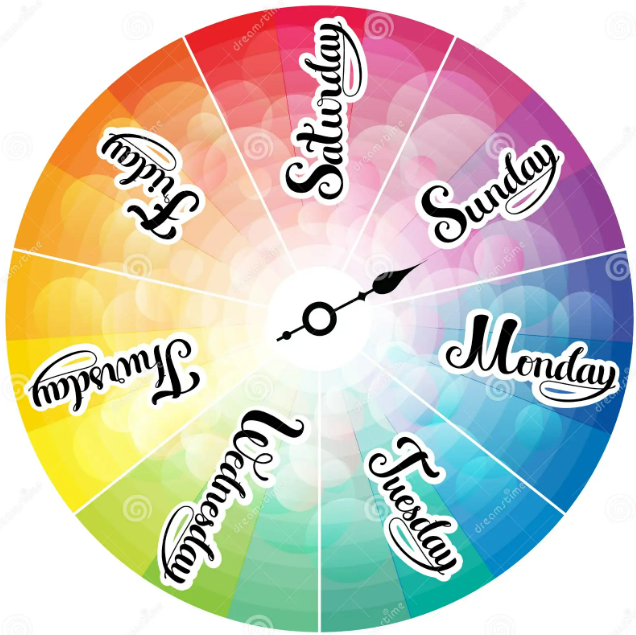

En vez de esto:

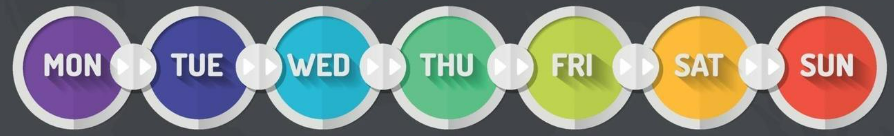

Para conseguirlo, necesitaremos reducir el tamaño de nuestras categorías (que irá desde el valor 0 hasta el número total de categorías) a este nuevo rango: [0, 2$\pi$], dado que son $2\pi$ radianes los que hay en 360º (una circunferencia).

En un ejemplo con 4 categorías:

In [ ]:
math.sin(0), math.cos(0) # el primer valor es 0, 1

(0.0, 1.0)

In [ ]:
math.sin(math.pi/2), math.cos(math.pi/2) # este sería el segundo valor

(1.0, 6.123233995736766e-17)

In [ ]:
math.sin(math.pi), math.cos(math.pi) # este sería el tercer valor

(1.2246467991473532e-16, -1.0)

In [ ]:
math.sin(3*math.pi/2), math.cos(3*math.pi/2) # y este el cuarto

(-1.0, -1.8369701987210297e-16)

In [ ]:
math.sin(2 * math.pi), math.cos(2 * math.pi) # el quinto valor daría la vuelta (es igual que el primero)

(-2.4492935982947064e-16, 1.0)

Para hacer esto de forma programática:
- Codificamos todas las categorías
- Comprimimos el intervalo
- Creamos dos columnas a las que asignamos el valor del seno y del coseno de cada nuevo valor.

In [ ]:
_df = df.copy() # creo una copia del conjunto de datos original

Ahora creo una función que me permita hacerlo de forma genérica. Más abajo explicamos mejor esta función, así que no hace falta que la mires con mucho detalle (salvo que realmente te interese).

**SIMPLIFICADO**: Quédate con la idea de que se asigna a cada valor un par (seno, coseno) que representa mejor la información si ésta es cíclica.

In [ ]:
def cyclic_encoder(dataframe, column, unique_values = None, verbose = True):
  # resultados
  result_x = []
  result_y = []

  # si no los tengo los infiero, aunque sería mejor tenerlos siempre para conocer el orden cíclico
  if not unique_values:
    unique_values = dataframe[column].unique() # valores de la categoría

  # comprimo el intervalo a [0, 2pi]
  cyclic_values = np.linspace(0, 2 * math.pi, num = len(unique_values) + 1)

  # creo el mapa de códigos
  code_map = {value: key for key, value in zip(cyclic_values, unique_values)}
  if verbose: print("Valores cíclicos asignados: ", code_map)

  # obtengo la codificación
  for value in dataframe[column]:
    code = code_map[value]
    result_x.append(math.sin(code))
    result_y.append(math.cos(code))

  # creo las nuevas columnas con la codificación que he obtenido
  dataframe = pd.concat([dataframe, pd.DataFrame({f"{column}_sin": result_x, f"{column}_cos": result_y})], axis=1) # lo añado en el eje X
  return dataframe.drop(columns=[column])

In [ ]:
cyclic_encoder(_df, "day", unique_values=["Thur", "Fri", "Sat", "Sun"])

Valores cíclicos asignados:  {'Thur': np.float64(0.0), 'Fri': np.float64(1.5707963267948966), 'Sat': np.float64(3.141592653589793), 'Sun': np.float64(4.71238898038469)}


,total_bill,tip,sex,smoker,time,size,day_sin,day_cos
0,16.99,1.01,Female,No,Dinner,2,-1.000000e+00,-1.836970e-16
1,10.34,1.66,Male,No,Dinner,3,-1.000000e+00,-1.836970e-16
2,21.01,3.50,Male,No,Dinner,3,-1.000000e+00,-1.836970e-16
3,23.68,3.31,Male,No,Dinner,2,-1.000000e+00,-1.836970e-16
4,24.59,3.61,Female,No,Dinner,4,-1.000000e+00,-1.836970e-16
...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Dinner,3,1.224647e-16,-1.000000e+00
240,27.18,2.00,Female,Yes,Dinner,2,1.224647e-16,-1.000000e+00
241,22.67,2.00,Male,Yes,Dinner,2,1.224647e-16,-1.000000e+00
242,17.82,1.75,Male,No,Dinner,2,1.224647e-16,-1.000000e+00


Y ahora, con estos valores, podríamos trabajar mejor.

## Datos categóricos sin ningún tipo de orden

Cuando tengamos datos categóricos que no tengan ningún tipo de orden, debemos asegurarnos que la conversión que hagamos tampoco tenga ningún tipo de orden: ni numérico ni de ningún otro tipo. Si introducimos un orden en un conjunto, el modelo que creemos aprenderá de ese orden y estará **sesgado**, asignando más importancia a aquellos elementos que, fortuitamente (o quizá no tanto ;) hayan quedado en las posiciones más ventajosas. Para evitar esto, usaremos distintas técnicas de codificación. El uso de estas técnicas, generalmente, depende del tamaño del problema, así que es interesante que, al menos, las conozcas todas.

### One Hot Encoding

Esta técnica se basa en crear tantas columnas extras como datos categóricos tengamos en el conjunto de datos.

La **ventaja** es que es muy sencilla de aplicar y de entender, además de que, obviamente, elimina el orden en los datos.

La principal **desventaja** es que, si la columna categórica tiene muchos datos, aumentaremos en exceso la dimensionalidad de nuestro conjunto de datos (¡estamos haciendo justo lo contrario de lo que hacíamos en ```202```, ```203``` y ```204```! Estamos añadiendo columnas). Además, estas columnas que añadiremos estarán muy **espaciadas** (```sparse``` en inglés, concepto muy típico). Esto significa que almacenarán muy poca información útil (tendrán 1 uno y el resto serán ceros).

**En nuestro ejemplo** añadiremos 4 columnas: ```isThur```, ```isFri```, ```isSat``` y ```isSun```. El valor de estas columnas será 0 (si **NO** era) o 1 (si **SÍ** era). Veamos cómo podemos hacer esto:

In [ ]:
_df = df.copy() # creo una copia del conjunto de datos original

for value in df.day.unique(): # para cada valor categórico
  _match = df.day.apply(lambda day: int(day == value)) # _match porque match es una palabra reservada. Aplico un mapeo que me dice si el dato es o no es de ese día (0 o 1, porque hago int(bool))
  _df[f"is{value}"] = _match # creo una nueva columna llamada isValue (isThur, isFri ...) donde guardo esa información

_df.head()

,total_bill,tip,sex,smoker,day,time,size,isSun,isSat,isThur,isFri
0,16.99,1.01,Female,No,Sun,Dinner,2,1,0,0,0
1,10.34,1.66,Male,No,Sun,Dinner,3,1,0,0,0
2,21.01,3.50,Male,No,Sun,Dinner,3,1,0,0,0
3,23.68,3.31,Male,No,Sun,Dinner,2,1,0,0,0
4,24.59,3.61,Female,No,Sun,Dinner,4,1,0,0,0


Y finalmente elimino la columna ```day```.

In [ ]:
_df = _df.drop(columns=["day"])
_df.tail() # para ver por detrás

,total_bill,tip,sex,smoker,time,size,isSun,isSat,isThur,isFri
239,29.03,5.92,Male,No,Dinner,3,0,1,0,0
240,27.18,2.00,Female,Yes,Dinner,2,0,1,0,0
241,22.67,2.00,Male,Yes,Dinner,2,0,1,0,0
242,17.82,1.75,Male,No,Dinner,2,0,1,0,0
243,18.78,3.00,Female,No,Dinner,2,0,0,1,0


Como puedes observar, los valores de las columnas is... son siempre ceros, exceptuando aquella columna donde sí coincidía el día.

Esto que hemos hecho de forma manual se puede hacer también con una clase parecida al ```Imputer``` que vimos en ```203```.

Voy a crear otra vez la copia para ver cómo.

In [ ]:
_df = df.copy()

Ahora vamos a ver cómo podemos usar el ```OneHotEncoder```.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ohe = OneHotEncoder(sparse_output=False, dtype=int)
pred = ohe.fit_transform(_df.day.to_numpy().reshape(-1, 1))
pred[:10]

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

Y, cuando ya tenemos los resultados, los añadimos al conjunto de datos.

In [ ]:
_df = pd.concat([_df, pd.DataFrame(pred)], axis=1) # lo añade en el eje X, cuidado porque no les da nombre
_df = _df.drop(columns=["day"])
_df

,total_bill,tip,sex,smoker,time,size,0,1,2,3
0,16.99,1.01,Female,No,Dinner,2,0,0,1,0
1,10.34,1.66,Male,No,Dinner,3,0,0,1,0
2,21.01,3.50,Male,No,Dinner,3,0,0,1,0
3,23.68,3.31,Male,No,Dinner,2,0,0,1,0
4,24.59,3.61,Female,No,Dinner,4,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Dinner,3,0,1,0,0
240,27.18,2.00,Female,Yes,Dinner,2,0,1,0,0
241,22.67,2.00,Male,Yes,Dinner,2,0,1,0,0
242,17.82,1.75,Male,No,Dinner,2,0,1,0,0


Fíjate que de esta forma el proceso es más automático, pero el resultado no se entiende tan bien como antes (fíjate en los nombres de las columnas).

En cualquier caso, ¿podemos hacer esto de otra forma sin ocupar tanto espacio para estos valores?

### Binary encoding

Si nos preocupa más el espacio que la interpretabilidad podemos combinar la idea de crear columnas con la idea de los códigos. Básicamente, representaremos en binario los números asignados a cada categoría. En nuestro caso:
- Jueves: 0 -> 00
- Viernes: 1 -> 01
- Sábado: 2 -> 10
- Domingo: 3 -> 11

Fíjate que podemos, por tanto, guardar toda esta información (4 valores) en dos columnas. En general, necesitaremos $\log_{2}{n}$ columnas, donde ```n``` es el valor de categorías de la columna. En nuestro caso ```n=4```, así que necesitaremos dos columnas.

Desgraciadamente, no existe una forma automática de realizar esta conversión.

In [ ]:
_df = df.copy()

Voy a usar el módulo ```math``` para algunas operaciones.

In [ ]:
cols = math.ceil(math.log2(len(df.day.unique()))) # aplico la fórmula de log_2_n y lo aproximo al número más grande

In [ ]:
result = [] # resultados

for day in df.day:
  code = day2code[day] # recojo el código asignado
  b_code = format(code, "b") # lo convierto a binario
  b_code_a = b_code.rjust(cols, "0") # lo formateo hasta tamaño cols rellenando con 0
  value = list(b_code_a) # lo convierto a lista: cada elemento en una posición diferente 00 -> ["0", "0"]
  result.append(value)

result[:10]

[['0', '1'],
 ['0', '1'],
 ['0', '1'],
 ['0', '1'],
 ['0', '1'],
 ['0', '1'],
 ['0', '1'],
 ['0', '1'],
 ['0', '1'],
 ['0', '1']]

O de forma genérica (no te cortes en guardarte todo esto para la entrega y tu futuro):

In [ ]:
def binary_categorizer(dataframe, column, code_map: dict = None, cols: int = None):
  # resultados
  result = []

  # puede ser que me obliguen a que haya un número determinado de columnas
  if not cols:
    cols = math.ceil(math.log2(len(dataframe[column].unique()))) # aplico la fórmula de log_2_n y lo aproximo al número más grande

  # puede ser que no se conozca el mapa y tenga que inferirlo
  if not code_map:
    code_map = {value: key for key, value in enumerate(dataframe[column].unique())} # creo el mapa de forma genérica si no existe

  # realizo la codificación a binario, comprobando que puedo hacerlo para todos los valores
  for value in dataframe[column]:
    code = code_map[value] # recojo el código asignado
    b_code = format(code, "b") # lo convierto a binario

    if len(b_code) > cols: # cols no puede ser más pequeño que el código
      raise Exception(f"El número de columnas ({cols}) es demasiado pequeño para empaquetar la información ({len(b_code)}). Modifica el valor del atributo cols.")

    # realizo la codificación
    b_code_a = b_code.rjust(cols, "0") # lo formateo hasta tamaño cols rellenando con 0
    _value = list(b_code_a) # lo convierto a lista: cada elemento en una posición diferente 00 -> ["0", "0"]
    result.append(list(map(lambda v: int(v), _value))) # convierto la lista en una lista de enteros ["0", "0"] -> [0, 0]

  # defino las nuevas columnas y las añado a mi df
  new_columns_name = [f"{column}_{i}" for i in range(len(list(result[0])))] # les daré nombre a las nuevas columnas
  result_df = pd.DataFrame(result, index=dataframe.index, columns=new_columns_name) # creo un nuevo df con los resultados
  dataframe = pd.concat([dataframe, result_df], axis=1) # lo añado en el eje X respetando el orden
  return dataframe.drop(columns=[column]), code_map # también devuelvo el mapa de códigos, me será útil

In [ ]:
_df, code_map = binary_categorizer(_df, "day")
_df

,total_bill,tip,sex,smoker,time,size,day_0,day_1
0,16.99,1.01,Female,No,Dinner,2,0,0
1,10.34,1.66,Male,No,Dinner,3,0,0
2,21.01,3.50,Male,No,Dinner,3,0,0
3,23.68,3.31,Male,No,Dinner,2,0,0
4,24.59,3.61,Female,No,Dinner,4,0,0
...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Dinner,3,0,1
240,27.18,2.00,Female,Yes,Dinner,2,0,1
241,22.67,2.00,Male,Yes,Dinner,2,0,1
242,17.82,1.75,Male,No,Dinner,2,0,1


In [ ]:
code_map

{'Sun': 0, 'Sat': 1, 'Thur': 2, 'Fri': 3}

### Embedding encoding

Una última técnica sería utilizar un ```embedding``` para crear el código de las categorías. Esto lo veremos en el tema 6 (entenderemos qué es un ```embedding```), así que lo dejeamos para entonces.

## Datos categóricos con un orden **NO** importante

Finalmente, podemos tener datos categóricos que sí tengan un orden, pero que éste no importe para el problema.

En estos casos, podemos aplicar las técnicas anteriores para los datos SIN orden, dado que éste no nos interesa.

## Resumen

Durante este cuadernillo hemos visto cómo trabajar con categorías.

Básicamente, la idea principal es que **NO** podemos trabajar con texto, así que nuestra labor será encontrar la mejor forma de representar esos textos con números. Las posibilidades son muchas, y generalmente usaremos aquella que represente mejor nuestros datos, sobre todo conservando el orden (si lo hubiera y fuese importante) de nuestros datos.